In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
import string
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator

In [ ]:
df = pd.read_csv('Preprocessed_xxx.csv',sep=";")


In [ ]:
word_dict = {}
for i in range(0,len(df['Filtered_Text'])):
    sentence = df['Filtered_Text'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [ ]:
lexicon = pd.read_csv('Indonesia_Sentiment_Analysis/lexicon/full_lexicon_afa.csv',sep=";")
lexicon

In [ ]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [ ]:
lexicon['number_of_words'].value_counts()

In [ ]:
negasi = ['bukan','tidak','ga','gk','kgk','g','bkn','bkan','tdk','tdak']


In [ ]:
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

Sentiment Analysis with Lexicon

In [ ]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Filtered_Text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        # else:
        # # # if not, then check the root word
        #     kata_dasar = stemmer.stem(word)
        #     if kata_dasar in lexicon_word:
        #         sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # # if still negative, try to match the combination of words with the adjacent words
        #     elif(n_words>1):
        #         if ind-1>-1:
        #             back_1    = words[ind-1]+' '+word
        #             if (back_1 in lexicon_word):
        #                 sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
        #             elif(ind-2>-1):
        #                 back_2    = words[ind-2]+' '+back_1
        #                 if back_2 in lexicon_word:
        #                     sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [ ]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [ ]:
df['sentiment'] = df_sen['sentiment'].copy()
df

In [ ]:
cek_df = pd.DataFrame([])
cek_df['Real Text'] = df['Text'].copy()
cek_df['Clean Text'] = df['Filtered_Text'].copy()
cek_df['num_word'] = df['word_length'].copy()
cek_df['sentiment']  = df_sen['sentiment'].copy()
cek_df

In [ ]:
# Count values less than 0

# hdf = pd.read_csv('output_xl.csv',sep=";")
# df = hdf.sample(n=550, random_state=14)  # Set random_state for reproducibility

negative_count = (df['sentiment'] < 0).sum()

# Count values greater than or equal to 0
non_negative_count = (df['sentiment'] >= 0).sum()

print(f"Number of values less than 0: {negative_count}")
print(f"Number of values greater than or equal to 0: {non_negative_count}")

In [ ]:
ns_words = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)
len(ns_words)

In [ ]:
len({k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3)) })

In [ ]:
ns_words_list = {k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3))}

In [ ]:
ns_words_list

In [ ]:
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse=True)
sort_orders=sort_orders[0:20]
for i in sort_orders:
    print(i[0], i[1])

In [ ]:
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

In [ ]:
word_to_plot = df['Filtered_Text'].copy()

In [ ]:
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

In [ ]:
sort_orders = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)
sort_orders=sort_orders[0:50]
for i in sort_orders:
    print(i[0], i[1])

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame with a 'Words' column
# data = {'Words': ['banget', 'lambat', 'admin', 'wifi', 'pakai', 'direct', 'message', 'internet', 'nya', 'gangguan', 'jaringan', 'sih', 'bayar', 'si', 'deh', 'cek', 'mati', 'putus', 'jelek', 'tv', 'melulu', 'anak', 'anjing', 'benar', 'jam', 'halo', 'kasih', 'bermasalah', 'gabisa', 'rumah', 'error', 'pagi', 'mohon', 'respon', 'paket', 'malam', 'doang', 'terima', 'kak', 'eror', 'merah', 'tagihan', 'tai', 'gini', 'koneksi', 'dr', 'wa', 'saudara', 'laki-laki', 'lapor']}

# df = pd.DataFrame(data)

# Count the frequency of each word
# word_counts = df['Words'].value_counts()

# Sort the words by frequency in descending order
# sorted_word_counts = word_counts.sort_values(ascending=False)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='black', max_words=30, min_font_size=20).generate_from_frequencies(word_dict)

# Plot the word cloud
fig = plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

/var/folders/t2/lw7m_8k914jgqsvv48dm5gsm0000gn/T/ipykernel_13897/842872685.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment'], color='Purple', shade=True)


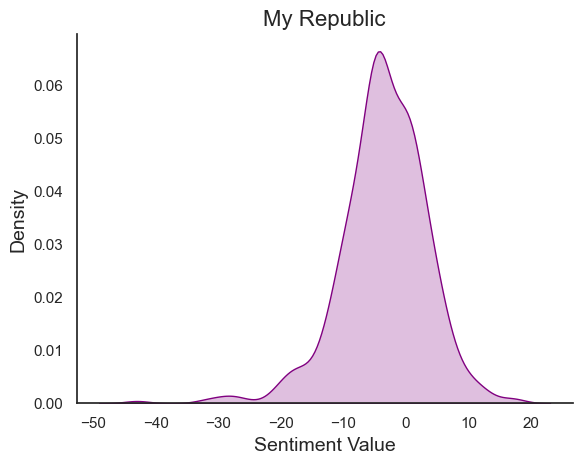

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style to white and use a blue color palette
sns.set(style="white", palette="deep")

# Create a KDE plot with blue color and shading
sns.kdeplot(df['sentiment'], color='Purple', shade=True)

# Set plot title, x-label, and y-label
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Adjust the plot's appearance
sns.despine()

# Save the plot as a PNG image with a transparent background
plt.savefig('sentiment_distribution_MR.png', dpi=300, bbox_inches='tight', transparent=True)

# Display the plot
plt.show()


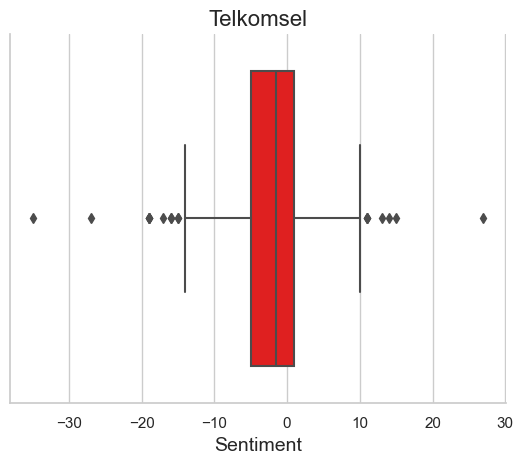

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style to whitegrid
sns.set(style="whitegrid")

# Create a boxplot with blue color
sns.boxplot(x=df['sentiment'], color='red')

# Set plot title and x-label
plt.title('Boxplot Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)

# Adjust the plot's appearance
sns.despine()

# Save the plot as a PNG image with a transparent background
plt.savefig('sentiment_boxplot.png', dpi=300, bbox_inches='tight', transparent=True)

# Display the plot
plt.show()


In [25]:
import pandas as pd
import numpy as np
from scipy import stats

# Calculate mean
mean_sentiment = df['sentiment'].mean()

# Calculate quartiles
q1 = df['sentiment'].quantile(0.25)
q3 = df['sentiment'].quantile(0.75)

# Calculate mode
mode_sentiment = df['sentiment'].mode().values[0]

# Calculate maximum and minimum
max_sentiment = df['sentiment'].max()
min_sentiment = df['sentiment'].min()

# Calculate interquartile range (IQR) for outlier detection
iqr = q3 - q1

# Define outlier range (values outside this range are potential outliers)
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Find outliers
outliers = df[(df['sentiment'] < lower_bound) | (df['sentiment'] > upper_bound)]

# Calculate density (assuming the data is normally distributed)
density = stats.norm(mean_sentiment, df['sentiment'].std()).pdf(df['sentiment'])

# Print the calculated statistics
print(f"Mean: {mean_sentiment}")
print(f"Quartile 1 (Q1): {q1}")
print(f"Quartile 3 (Q3): {q3}")
print(f"Mode: {mode_sentiment}")
print(f"Maximum: {max_sentiment}")
print(f"Minimum: {min_sentiment}")
print(f"Outlier Range (Lower Bound): {lower_bound}")
print(f"Outlier Range (Upper Bound): {upper_bound}")
print(f"Number of Outliers: {len(outliers)}")
print(f"Density: {density}")
# outliers.min()


Mean: -1.684
Quartile 1 (Q1): -5.0
Quartile 3 (Q3): 2.0
Mode: 0
Maximum: 18
Minimum: -24
Outlier Range (Lower Bound): -15.5
Outlier Range (Upper Bound): 12.5
Number of Outliers: 25
Density: [6.46081023e-02 6.23252426e-02 5.88466824e-02 6.23252426e-02
 6.32365252e-02 6.23252426e-02 6.42962501e-02 8.80476085e-03
 3.20056912e-02 6.02876956e-02 6.46081023e-02 3.82884830e-02
 3.59542917e-02 4.23032798e-02 4.23032798e-02 6.02876956e-02
 6.32365252e-02 5.06394612e-02 5.59846598e-02 2.97650838e-02
 2.97650838e-02 2.97650838e-02 5.59846598e-02 3.59542917e-02
 5.06394612e-02 6.02876956e-02 5.59846598e-02 5.88466824e-02
 5.41202336e-02 1.88520625e-02 6.02876956e-02 5.59846598e-02
 5.59846598e-02 5.88466824e-02 3.82884830e-02 6.23252426e-02
 5.41202336e-02 6.42962501e-02 2.60594914e-02 6.23252426e-02
 5.88466824e-02 1.88520625e-02 1.44229554e-02 3.59542917e-02
 6.23252426e-02 6.02876956e-02 6.42962501e-02 5.59846598e-02
 1.59654956e-02 2.97650838e-02 2.97650838e-02 6.02876956e-02
 5.88466824e-02 4

In [ ]:
import pandas as pd

# Calculate the value counts for each unique value in the 'sentiment' column
value_counts = df['sentiment'].value_counts()

# Get the second most frequent value (second mode)
second_mode_value = value_counts.index[1]

# Print the second mode value
print(f"Second Mode Value: {second_mode_value}")

In [ ]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Filtered_Text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        # else:
        # # # if not, then check the root word
        #     kata_dasar = stemmer.stem(word)
        #     if kata_dasar in lexicon_word:
        #         sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # # if still negative, try to match the combination of words with the adjacent words
        #     elif(n_words>1):
        #         if ind-1>-1:
        #             back_1    = words[ind-1]+' '+word
        #             if (back_1 in lexicon_word):
        #                 sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
        #             elif(ind-2>-1):
        #                 back_2    = words[ind-2]+' '+back_1
        #                 if back_2 in lexicon_word:
        #                     sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    df_corr = au_corr.reset_index(name='Correlation')
    
    return df_corr


print("Top Absolute Correlations")
print(get_top_abs_correlations(df_sen, 10))
au = get_top_abs_correlations(df_sen, 15)

In [ ]:
au

In [ ]:
au.to_csv('Complete_Analysis.csv', sep=';', index=False)